# EDA

In [1]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties

In [2]:
import sys
sys.path.append('/home/work')

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import split, col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, count, desc

from data.utils.data_loader import load_file_from_hdfs

In [4]:
conf = pyspark.SparkConf()
settings = conf.getAll()

# Set Spark Settings
conf = pyspark.SparkConf().setAll([
('spark.master', 'local[*]'),
('spark.app.name', 'MusicRecommender'),
('spark.driver.memory','14g')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Print the Spark Session settings
settings = spark.sparkContext.getConf().getAll()
for s in settings:
    print(s)

('spark.executor.id', 'driver')
('spark.app.submitTime', '1716348425532')
('spark.app.startTime', '1716348425652')
('spark.driver.port', '45433')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false')
('spark.rdd.

In [8]:
# Load the dataset
song_ratings_file_path = "raw/train/train_0.txt"
song_ratings = load_file_from_hdfs(song_ratings_file_path)

song_attributes_file_path = "song-attributes.txt"
song_attributes = load_file_from_hdfs(song_attributes_file_path)

genre_hierarchy_file_path = "genre-hierarchy.txt"
genre_hierarchy = load_file_from_hdfs(genre_hierarchy_file_path)

In [6]:
def perform_eda(df):
    print("The schema of the dataframe:")
    df.printSchema()

    print("Summary Statistics:")
    df.summary().show()
    
    ratings = df.count()
    print("Number of ratings: ", ratings)
    
    rating_range = df.agg(min("rating").alias("min_rating"), max("rating").alias("max_rating")).collect()[0]
    print("Range of ratings:", rating_range)
    
    users = df.groupBy("user_id").count()
    print("Number of unique users: ", users.count())

    songs = df.groupBy("song_id").count()
    print("Number of unique songs: ", songs.count())

    return df

##### Display first 5 row of song ratings dataframe

In [9]:
song_ratings.show(5)

+---+----+---+
|_c0| _c1|_c2|
+---+----+---+
|  0| 166|  5|
|  0|2245|  4|
|  0|3637|  4|
|  0|5580|  4|
|  0|5859|  4|
+---+----+---+
only showing top 5 rows



In [10]:
song_attributes.show(5)

+---+-----+----+---+
|_c0|  _c1| _c2|_c3|
+---+-----+----+---+
|  0|12070|8490|  0|
|  1|19512|7975|134|
|  2|18953|3492|  0|
|  3|  695|2653|  0|
|  4|  243|2282|  0|
+---+-----+----+---+
only showing top 5 rows



In [11]:
genre_hierarchy.show(5)

+---+---+---+----------------+
|_c0|_c1|_c2|             _c3|
+---+---+---+----------------+
|  0|  0|  1|         Unknown|
|  1|  1|  1|Electronic/Dance|
|  2|  1|  2|         Ambient|
|  3|  2|  3|     Ambient Dub|
|  4|  2|  3|    Ambient Tech|
+---+---+---+----------------+
only showing top 5 rows



##### Update column names

In [10]:
df = df.withColumnRenamed("_c0", "user_id") \
    .withColumnRenamed("_c1", "song_id") \
    .withColumnRenamed("_c2", "rating") 

In [11]:
perform_eda(df)

The schema of the dataframe:
root
 |-- user_id: integer (nullable = true)
 |-- song_id: integer (nullable = true)
 |-- rating: integer (nullable = true)

Summary Statistics:


+-------+------------------+------------------+------------------+
|summary|           user_id|           song_id|            rating|
+-------+------------------+------------------+------------------+
|  count|          76344627|          76344627|          76344627|
|   mean|100040.94482474844| 68279.70831871378|3.1534895834909245|
| stddev| 57753.04973969481|39461.312338210184| 1.599535981362968|
|    min|                 0|                 0|                 1|
|    25%|             49825|             34391|                 1|
|    50%|            100133|             68311|                 3|
|    75%|            149813|            102348|                 5|
|    max|            199999|            136735|                 5|
+-------+------------------+------------------+------------------+



Number of ratings:  76344627


Number of unique users:  200000


Number of unique songs:  136736


DataFrame[user_id: int, song_id: int, rating: int]

#### EDA on songs with ratings train data file

#### EDA on song attribute file

In [9]:
song_attributes = spark.read.text("file:///home/work/Project/yahoo_dataset/song-attributes.txt").cache()
song_attributes.printSchema()
print(song_attributes.count())

root
 |-- value: string (nullable = true)

136736


In [10]:
song_attributes.show(5)

+-------------------+
|              value|
+-------------------+
|  0\t12070\t8490\t0|
|1\t19512\t7975\t134|
|  2\t18953\t3492\t0|
|    3\t695\t2653\t0|
|    4\t243\t2282\t0|
+-------------------+
only showing top 5 rows



In [11]:
song_attributes = song_attributes.withColumn("song_id", split(song_attributes.value, "\t")[0]) \
       .withColumn("album_id", split(song_attributes.value, "\t")[1]) \
       .withColumn("artist_id", split(song_attributes.value, "\t")[2]) \
       .withColumn("genre_id", split(song_attributes.value, "\t")[3]) \
       .drop("value")

In [12]:
song_attributes.printSchema()

root
 |-- song_id: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- genre_id: string (nullable = true)



In [13]:
song_attributes = song_attributes.withColumn("song_id", col("song_id").cast("integer")) \
       .withColumn("album_id", col("album_id").cast("integer")) \
       .withColumn("artist_id", col("artist_id").cast("integer"))
song_attributes.printSchema()

root
 |-- song_id: integer (nullable = true)
 |-- album_id: integer (nullable = true)
 |-- artist_id: integer (nullable = true)
 |-- genre_id: string (nullable = true)



In [14]:
song_attributes.show(5)

+-------+--------+---------+--------+
|song_id|album_id|artist_id|genre_id|
+-------+--------+---------+--------+
|      0|   12070|     8490|       0|
|      1|   19512|     7975|     134|
|      2|   18953|     3492|       0|
|      3|     695|     2653|       0|
|      4|     243|     2282|       0|
+-------+--------+---------+--------+
only showing top 5 rows



#### EDA on genre hierarchy file

In [15]:
genre_hierarchy = spark.read.text("file:///home/work/Project/yahoo_dataset/genre-hierarchy.txt").cache()
genre_hierarchy.printSchema()

root
 |-- value: string (nullable = true)



In [16]:
genre_hierarchy.show(5)

+--------------------+
|               value|
+--------------------+
|    0\t0\t1\tUnknown|
|1\t1\t1\tElectron...|
|    2\t1\t2\tAmbient|
|3\t2\t3\tAmbient Dub|
|4\t2\t3\tAmbient ...|
+--------------------+
only showing top 5 rows



In [17]:
genre_hierarchy = genre_hierarchy.withColumn("genre_id", split(genre_hierarchy.value, "\t")[0]) \
       .withColumn("parent_genre_id", split(genre_hierarchy.value, "\t")[1]) \
       .withColumn("level", split(genre_hierarchy.value, "\t")[2]) \
       .withColumn("genre_name", split(genre_hierarchy.value, "\t")[3]) \
       .drop("value")

In [18]:
genre_hierarchy.printSchema()
print(genre_hierarchy.count())

root
 |-- genre_id: string (nullable = true)
 |-- parent_genre_id: string (nullable = true)
 |-- level: string (nullable = true)
 |-- genre_name: string (nullable = true)

216


In [19]:
genre_hierarchy = genre_hierarchy.withColumn("genre_id", col("genre_id").cast("integer")) \
       .withColumn("parent_genre_id", col("parent_genre_id").cast("integer")) \
       .withColumn("level", col("level").cast("integer"))
genre_hierarchy.printSchema()

root
 |-- genre_id: integer (nullable = true)
 |-- parent_genre_id: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- genre_name: string (nullable = true)



In [20]:
genre_hierarchy.show(5)

+--------+---------------+-----+----------------+
|genre_id|parent_genre_id|level|      genre_name|
+--------+---------------+-----+----------------+
|       0|              0|    1|         Unknown|
|       1|              1|    1|Electronic/Dance|
|       2|              1|    2|         Ambient|
|       3|              2|    3|     Ambient Dub|
|       4|              2|    3|    Ambient Tech|
+--------+---------------+-----+----------------+
only showing top 5 rows



#### Joining all files together based on song_id and genre_id

In [21]:
df = song_ratings.join(song_attributes, "song_id", how="inner")
df = df.join(genre_hierarchy,"genre_id", how="inner")

In [22]:
df = df.drop('parent_genre_id').drop('level')
df.describe().show()

+-------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+
|summary|         genre_id|          song_id|          user_id|          ratings|         album_id|         artist_id|       genre_name|
+-------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+
|  count|          1000000|          1000000|          1000000|          1000000|          1000000|           1000000|          1000000|
|   mean|        16.756151|     68299.584969|      1322.364986|         3.184917|     10344.492844|       4776.511339|             NULL|
| stddev|43.16625508416077|39474.06865195663|789.1489184439173|1.579644010018165|5917.110782128683|2687.8513016557085|             NULL|
|    min|                0|                0|                0|                1|                0|                 0|Adult Alternative|
|    max|               88|           136

In [23]:
null_columns = {column: df.filter(col(column).isNull()).count() for column in df.columns}
null_columns

{'genre_id': 0,
 'song_id': 0,
 'user_id': 0,
 'ratings': 0,
 'album_id': 0,
 'artist_id': 0,
 'genre_name': 0}

In [24]:
df.show(10)

+--------+-------+-------+-------+--------+---------+------------+
|genre_id|song_id|user_id|ratings|album_id|artist_id|  genre_name|
+--------+-------+-------+-------+--------+---------+------------+
|       0|    166|      0|      5|    5303|     7231|     Unknown|
|       0|   2245|      0|      4|   14290|     3265|     Unknown|
|       0|   3637|      0|      4|   15761|      629|     Unknown|
|       0|   5580|      0|      4|    8324|     4761|     Unknown|
|       0|   5859|      0|      4|   19671|     4716|     Unknown|
|       0|   7121|      0|      3|    5303|     7372|     Unknown|
|       0|  10405|      0|      4|    5303|     7149|     Unknown|
|       0|  16794|      0|      5|    2517|     7620|     Unknown|
|     135|  17821|      0|      5|    8620|     2020|Classic Rock|
|       0|  21252|      0|      4|   15761|     2535|     Unknown|
+--------+-------+-------+-------+--------+---------+------------+
only showing top 10 rows



In [25]:
df.groupBy('genre_name').count().show()
print(df.groupBy('genre_name').count().count())

+------------------+------+
|        genre_name| count|
+------------------+------+
|           Unknown|858819|
|      Classic Rock|  4508|
|              Rock| 68604|
|               Pop| 22968|
|           Country|  7042|
|               R&B| 16819|
|Adult Contemporary|  1218|
|    Easy Listening|   589|
|Shows &amp; Movies|   300|
|               Rap|  4526|
|       Classic R&B|   862|
|    Mainstream Pop|    39|
|             World|   137|
|        Vocal Jazz|   209|
|            Reggae|  1257|
|       Modern Rock|   401|
|        R&B Gospel|   129|
|              Folk|   959|
|         Christmas|   435|
| Adult Alternative|   861|
+------------------+------+
only showing top 20 rows



58


In [26]:



# users and number amnt ratings comparison x
# ratings count by genre -  rating distribution x
# average ratings genre box x
# ratings avg by artist top 10... box/avg x
# ratings avg by song top 10. box/avg x
# ratings count by artist top 10... x
# ratings cnt by song top 10. x
# songs in genre breakdown x
# songs in album breakdown?


#correlation heatmap - could show popular suggestions comparison? 
#network graph artists, albums, and songs....

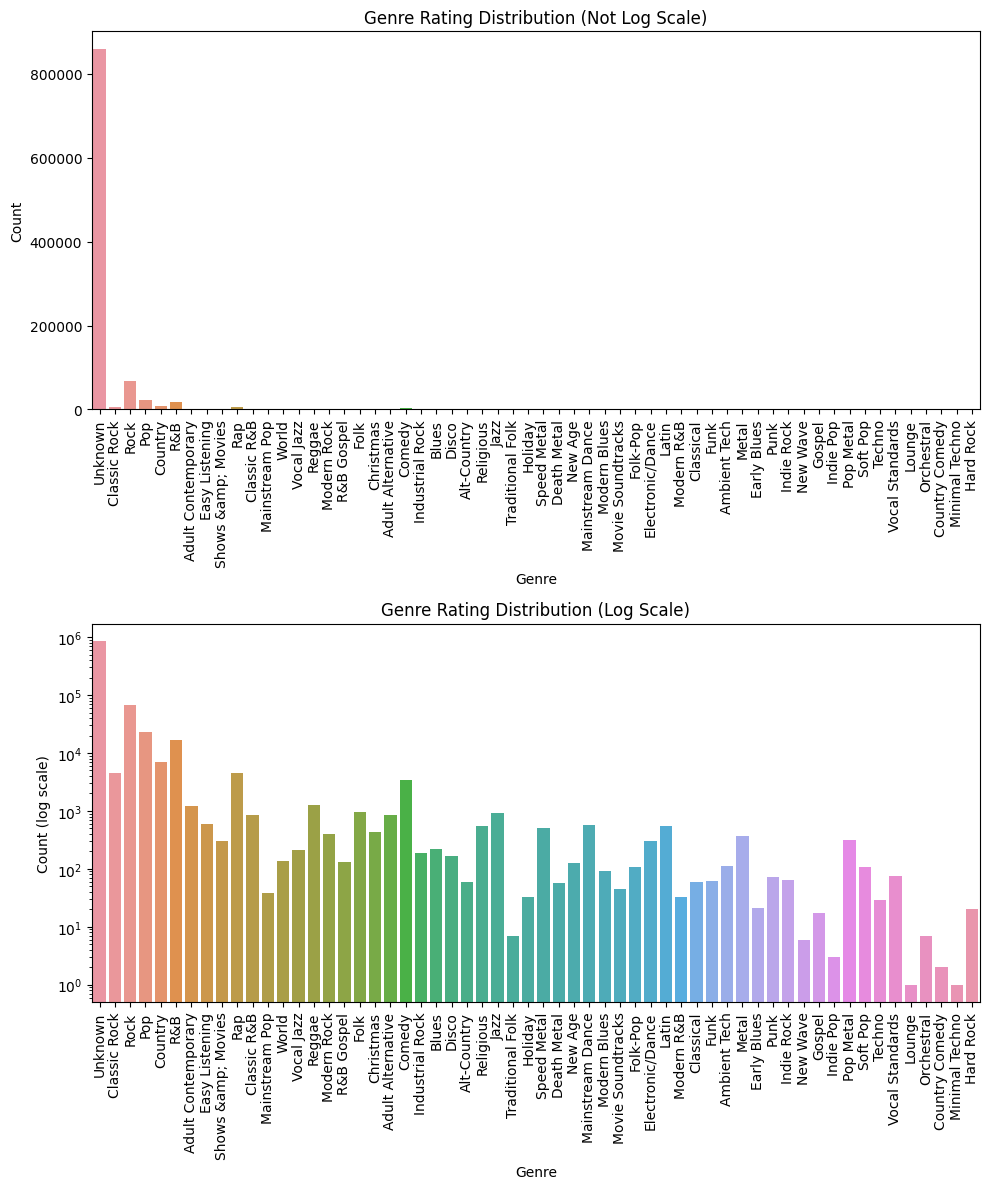

In [27]:
# genre count dist

genre_pdf = df.select('genre_name').toPandas()
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# no log
sns.countplot(data=genre_pdf, x='genre_name', ax=axes[0])
axes[0].set_title('Genre Rating Distribution (Not Log Scale)')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

# log
sns.countplot(data=genre_pdf, x='genre_name', ax=axes[1])
axes[1].set_title('Genre Rating Distribution (Log Scale)')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Count (log scale)')
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [28]:
# users and number amnt ratings comparison

# number of users with x number of ratings
# might be too big to grpah with size 845

num_user_rating = df.groupBy('user_id').count()
print(num_user_rating.count())
# number of ratings and its number of users
num_rating_users = num_user_rating.groupBy('count').count()
print(num_rating_users.count())
num_rating_users.show()
#num ratings vs num users with rating count

2677


845


+-----+-----+
|count|count|
+-----+-----+
|   34|   14|
|  387|    1|
|  358|    1|
|  122|    8|
|   70|   12|
|   21|   33|
| 1349|    2|
|  125|    6|
|  539|    2|
|  181|    4|
|  580|    1|
|  705|    2|
|  164|    4|
|   25|   14|
|  256|    5|
|   54|   15|
|  103|    7|
|   64|   14|
|  394|    4|
| 1365|    1|
+-----+-----+
only showing top 20 rows



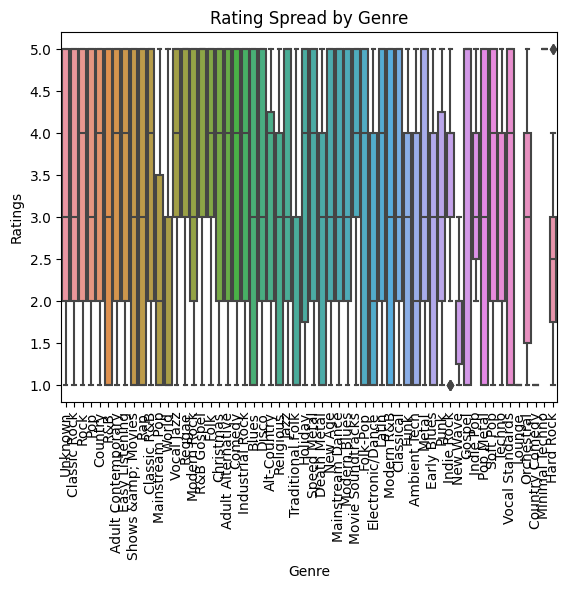

In [29]:
pdf = df.toPandas()
sns.boxplot(data=pdf, x='genre_name', y='ratings')
plt.title('Rating Spread by Genre')
plt.xlabel('Genre')
plt.ylabel('Ratings')
plt.xticks(rotation=90)
plt.show()

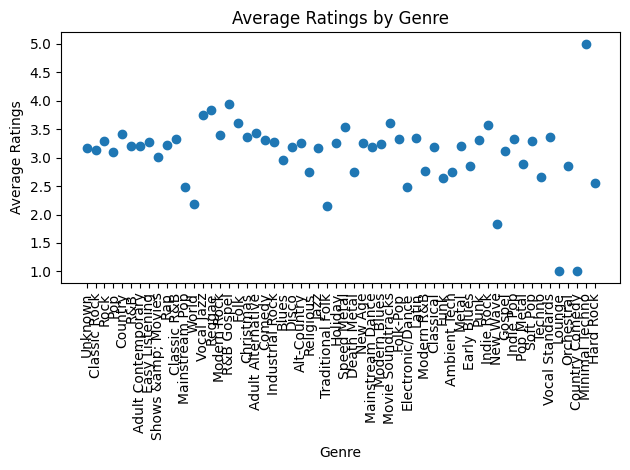

In [30]:
genre_rating_avg_pdf = df.groupBy('genre_name').avg('ratings').toPandas()

plt.scatter(data=genre_rating_avg_pdf, x='genre_name', y='avg(ratings)')
plt.title('Average Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Ratings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

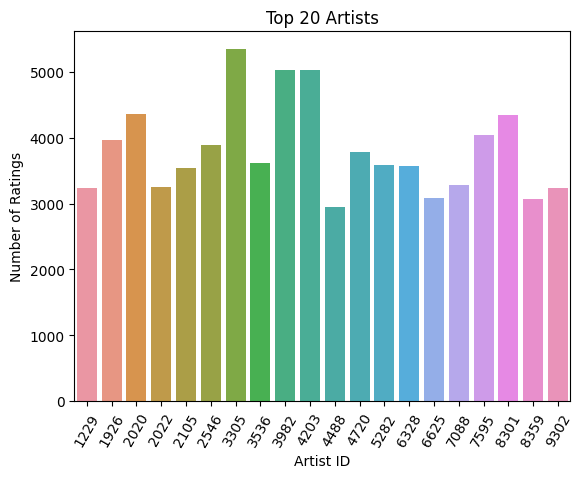

In [31]:
# top 20 artist (detemined by number of ratings)

artist_ratings_count = df.groupBy('artist_id').count()
top_20_artists = artist_ratings_count.orderBy('count', ascending=False).limit(20)
top_20_artists_pdf= top_20_artists.toPandas()

sns.barplot(data=top_20_artists_pdf, x='artist_id', y='count')
plt.title('Top 20 Artists')
plt.xlabel('Artist ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=60)
plt.show()


In [32]:
top_20_artists.show(20)

+---------+-----+
|artist_id|count|
+---------+-----+
|     3305| 5347|
|     3982| 5033|
|     4203| 5030|
|     2020| 4365|
|     8301| 4340|
|     7595| 4047|
|     1926| 3964|
|     2546| 3896|
|     4720| 3779|
|     3536| 3610|
|     5282| 3580|
|     6328| 3572|
|     2105| 3545|
|     7088| 3283|
|     2022| 3251|
|     9302| 3242|
|     1229| 3239|
|     6625| 3086|
|     8359| 3076|
|     4488| 2953|
+---------+-----+



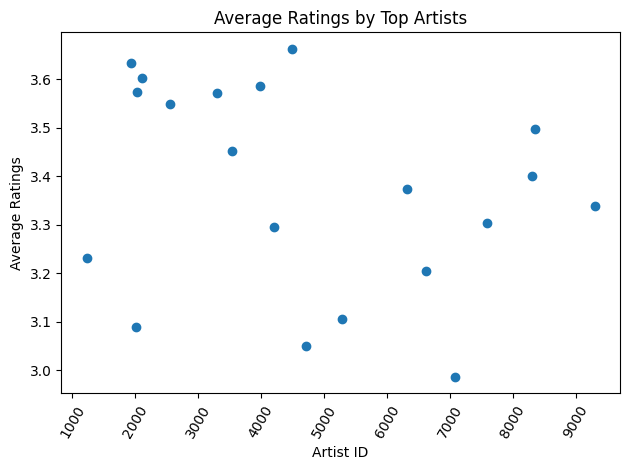

In [33]:
# avg artists

top_20_artists_df = top_20_artists.join(df, 'artist_id', 'inner')
top_artists_rating_avg_pdf= top_20_artists_df.groupBy('artist_id').avg('ratings').toPandas()

plt.scatter(data=top_artists_rating_avg_pdf, x='artist_id', y='avg(ratings)')
plt.title('Average Ratings by Top Artists')
plt.xlabel('Artist ID')
plt.ylabel('Average Ratings')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

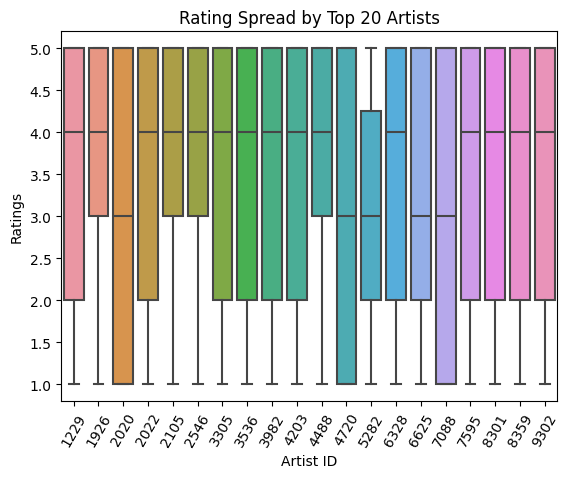

In [34]:
sns.boxplot(data=top_20_artists_df.toPandas(), x='artist_id', y='ratings')
plt.title('Rating Spread by Top 20 Artists')
plt.xlabel('Artist ID')
plt.ylabel('Ratings')
plt.xticks(rotation=60)
plt.show()

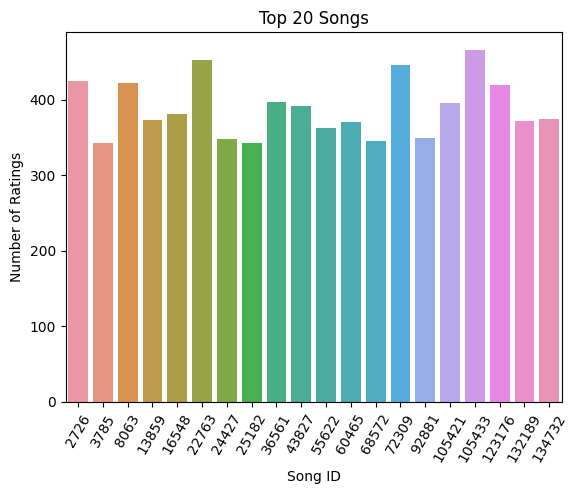

In [35]:
# top 20 songs (detemined by number of ratings)

song_ratings_count = df.groupBy('song_id').count()
top_20_songs = song_ratings_count.orderBy('count', ascending=False).limit(20)
top_20_songs_pdf= top_20_songs.toPandas()

sns.barplot(data=top_20_songs_pdf, x='song_id', y='count')
plt.title('Top 20 Songs')
plt.xlabel('Song ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=60)
plt.show()


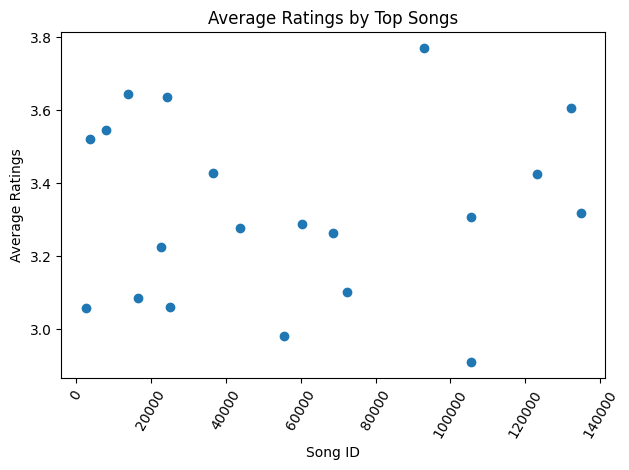

In [36]:
# avg artists

top_20_songs_df = top_20_songs.join(df, 'song_id', 'inner')
top_songs_rating_avg_pdf= top_20_songs_df.groupBy('song_id').avg('ratings').toPandas()

plt.scatter(data=top_songs_rating_avg_pdf, x='song_id', y='avg(ratings)')
plt.title('Average Ratings by Top Songs')
plt.xlabel('Song ID')
plt.ylabel('Average Ratings')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

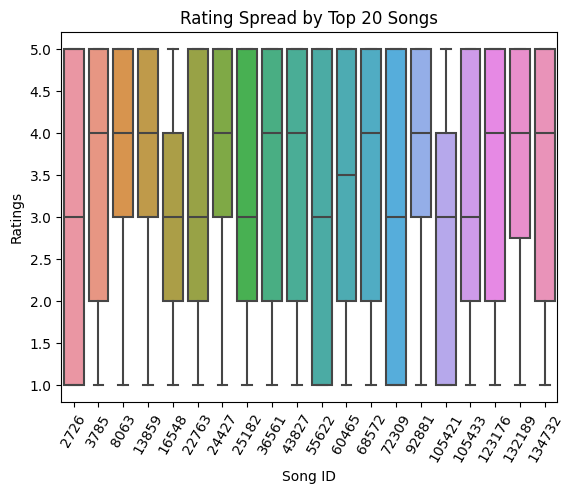

In [37]:
sns.boxplot(data=top_20_songs_df.toPandas(), x='song_id', y='ratings')
plt.title('Rating Spread by Top 20 Songs')
plt.xlabel('Song ID')
plt.ylabel('Ratings')
plt.xticks(rotation=60)
plt.show()

In [38]:
genre_song_count = df.groupBy('genre_name').agg(f.count('song_id').alias('genre_song_count'))
genre_song_count = genre_song_count.orderBy('genre_song_count', ascending=False)
#print(genre_song_count.count())
genre_song_count.show()

+------------------+----------------+
|        genre_name|genre_song_count|
+------------------+----------------+
|           Unknown|          858819|
|              Rock|           68604|
|               Pop|           22968|
|               R&B|           16819|
|           Country|            7042|
|               Rap|            4526|
|      Classic Rock|            4508|
|            Comedy|            3438|
|            Reggae|            1257|
|Adult Contemporary|            1218|
|              Folk|             959|
|              Jazz|             907|
|       Classic R&B|             862|
| Adult Alternative|             861|
|    Easy Listening|             589|
|  Mainstream Dance|             576|
|             Latin|             559|
|         Religious|             548|
|       Speed Metal|             513|
|         Christmas|             435|
+------------------+----------------+
only showing top 20 rows



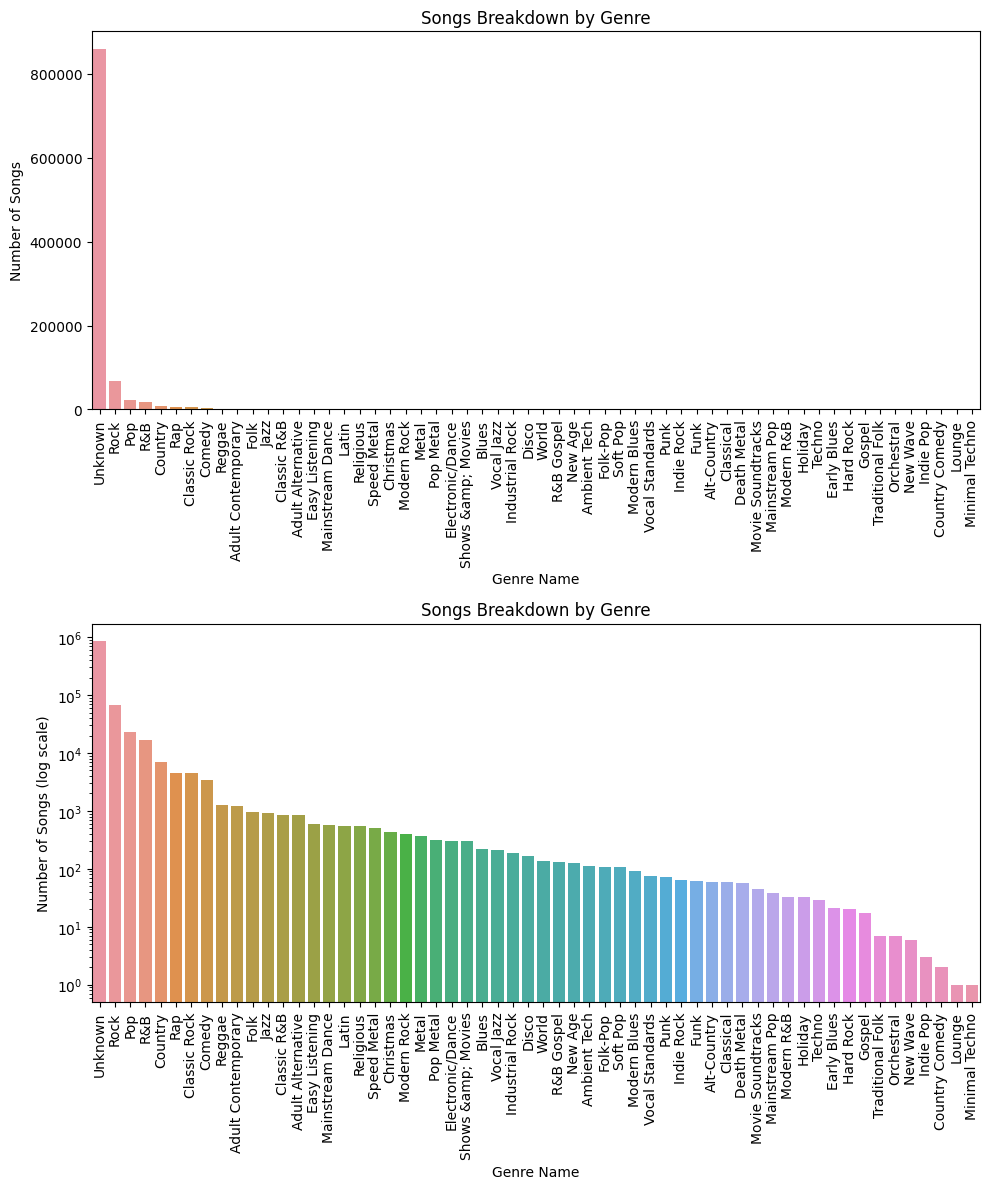

In [39]:
# song in genre breakdown

genre_song_count_pdf = genre_song_count.toPandas()
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

sns.barplot(data=genre_song_count_pdf, x='genre_name', y='genre_song_count', ax=axes[0])
axes[0].set_title('Songs Breakdown by Genre')
axes[0].set_xlabel('Genre Name')
axes[0].set_ylabel('Number of Songs')
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(data=genre_song_count_pdf, x='genre_name', y='genre_song_count', ax=axes[1])
axes[1].set_title('Songs Breakdown by Genre')
axes[1].set_xlabel('Genre Name')
axes[1].set_ylabel('Number of Songs (log scale)')
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

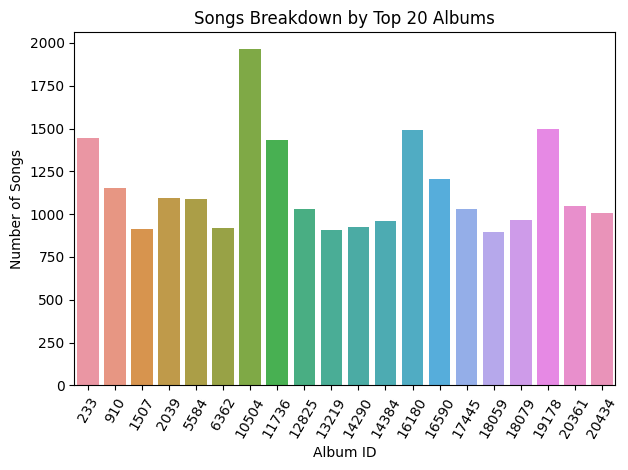

In [40]:
# song in album breakdown top 20 (determined by most rated songs in album)
album_song_count = df.groupBy('album_id').agg(f.count('song_id').alias('album_song_count'))

album_song_count = album_song_count.orderBy('album_song_count', ascending=False).limit(20)
#print(album_song_count.count())
#genre_song_count.show()

album_song_count_pdf = album_song_count.toPandas()

sns.barplot(data=album_song_count_pdf, x='album_id', y='album_song_count')
plt.title('Songs Breakdown by Top 20 Albums')
plt.xlabel('Album ID')
plt.ylabel('Number of Songs')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()